<a href="https://colab.research.google.com/github/sotamls-itmo/tutorials/blob/main/cv_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements

In [1]:
# for train-loop pipeline
!pip install pytorch-lightning==1.0.3

# for augmentations
!pip install albumentations==0.4.3

!pip install efficientnet-pytorch==0.6.3

In [2]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from pathlib import Path
import numpy as np
import random

import torch
from torch import nn
from torch.nn import functional as F
import torchvision

## Reproducibility of experiments

In [3]:
def set_seed(seed: int = 24):
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

# Finetuning EfficientNet for classification task
For this tutorial, we will be finetuning a pre-trained EfficientNet model in simple dataset just to show general CV pipeline.

# Data
For demonstration purpose we will use tiny dataset with 2 classes: bees and ants. There are 245 images in trainning set and 153 images in validation.   

In [4]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip >> /dev/null

--2020-10-24 07:43:46--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.207.111, 13.32.207.27, 13.32.207.54, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.207.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.1’

hymenoptera_data.zi 100%[===================>]  45.10M   100MB/s    in 0.4s    

2020-10-24 07:43:46 (100 MB/s) - ‘hymenoptera_data.zip.1’ saved [47286322/47286322]



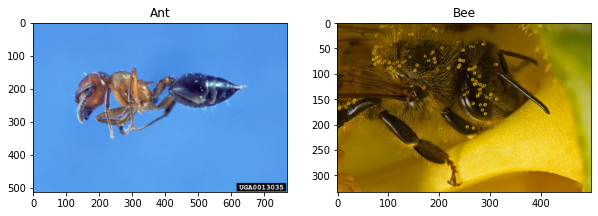

In [5]:
  plt.figure(figsize=(10, 14))
  
  plt.subplot(1, 2, 1)
  plt.imshow(Image.open('/content/hymenoptera_data/train/ants/0013035.jpg'))
  plt.title('Ant')

  plt.subplot(1, 2, 2)
  plt.imshow(Image.open('/content/hymenoptera_data/train/bees/1092977343_cb42b38d62.jpg'))
  plt.title('Bee');

[![Albumentation logo](https://albumentations.readthedocs.io/en/latest/_static/logo.png)](https://github.com/albu/albumentations)

## Augmentations
The [albumentation](https://github.com/albu/albumentations) library works with images, masks, keypoints at the same time.

![mask_and_bbox_aug](https://camo.githubusercontent.com/dfd2d57c087ff30d68958c4ff1aec17a5fdd6b77/68747470733a2f2f686162726173746f726167652e6f72672f776562742f727a2f2d682f336a2f727a2d68336a616c62786963386f5f6668756378797374733474632e6a706567)


![key_points_aug](https://camo.githubusercontent.com/041633dc5d522d6cf583a81d4a1d85be87f44155/68747470733a2f2f686162726173746f726167652e6f72672f776562742f652d2f366b2f7a2d2f652d366b7a2d66756770326865616b336a7a6e733362632d72386f2e6a706567)





In [6]:
import albumentations as albu
from albumentations.pytorch import ToTensor


def pre_transforms(image_size=224):
    return [albu.Resize(image_size, image_size, p=1)]


def aug_transforms():
    return [
        albu.VerticalFlip(p=0.5),
        albu.HorizontalFlip(p=0.5),
        albu.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2, p=0.3
        )]


def post_transforms():
    return [albu.Normalize(), ToTensor()]

In [7]:
show_transforms = albu.Compose(pre_transforms() + aug_transforms())
train_transforms = albu.Compose(pre_transforms() + aug_transforms() + post_transforms())
valid_transforms = albu.Compose(pre_transforms() + post_transforms())

## Dataset

In [8]:
from torch.utils.data import Dataset


class AntAndBeeDataset(Dataset):
    class_mapping = {
        'ants': 0,
        'bees': 1,
    }

    def __init__(self,
                 dataset_path: Path,
                 transforms=None):
        self.transforms = transforms
        self.image_paths = []
        self.labels = []

        for label_dir_path in dataset_path.glob('*'):
            for image_path in label_dir_path.glob('*.jpg'):
                self.image_paths.append(image_path)
                self.labels.append(self.class_mapping[label_dir_path.name])

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        result = {'image': image}

        if self.transforms is not None:
            # result = self.transforms(**result)
            result['image'] = self.transforms(image=image)['image']

        result['label'] = self.labels[idx]
        result['filename'] = image_path.name

        return result


In [9]:
show_dataset = AntAndBeeDataset(Path('hymenoptera_data/train'), transforms=show_transforms)
train_dataset = AntAndBeeDataset(Path('hymenoptera_data/train'), transforms=train_transforms)
valid_dataset = AntAndBeeDataset(Path('hymenoptera_data/val'), transforms=valid_transforms)

label: 0
filename: 403746349_71384f5b58.jpg


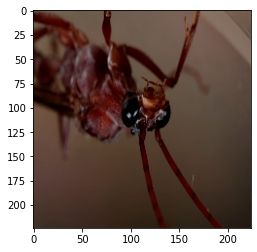

In [10]:
it = show_dataset[1]

for k, v in it.items():
    if k == 'image':
        plt.imshow(v)
    else:
        print(f'{k}: {v}')    

## Dataloader

In [11]:
from torch.utils.data import DataLoader


batch_size = 8
num_workers = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)

## Model

![EfficientNet](https://www.learnopencv.com/wp-content/uploads/2019/06/EfficientNet-B0-architecture-1024x511.png)

In [12]:
from efficientnet_pytorch import EfficientNet


effnet = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [13]:
effnet

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

![PL](https://www.learnopencv.com/wp-content/uploads/2020/05/PTL-1024x408.png)
## PyTorch Lightning

In [14]:
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy

In [15]:
class EfficientNetClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def configure_optimizers(self):
        # Train only last Linear layer
        return torch.optim.Adam(self.model._fc.parameters(), lr=0.001)
        
    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch['image'], batch['label']
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch['image'], batch['label']
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)
        

In [16]:
# Init our model
insect_model = EfficientNetClassifier(effnet)

# Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=20)

# Train the model ⚡
trainer.fit(insect_model, train_loader, valid_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 4 M   


1